In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import functions
import neural
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
functions.folder = r"D:\Projects\MLIA Set\CAP Sleep"
filelist = os.listdir(functions.folder)

In [4]:
learning_rate= 0.0005
epochs = 200
features = 11
classes = 2
categories = []
train_data = {}
test_data = {}

Define Neural Network

In [5]:
class Baseline001(nn.Module):
    debug = False
    def __init__(self):
        super(Baseline001, self).__init__()
        #self.conv0 = nn.conv1d(4,1,kernel_size=2,stride=1,padding=1)
        self.fc1 = nn.Linear(features, 24)
        self.bn1 = nn.BatchNorm1d(24)
        self.drop2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(24, 12)
        self.bn3 = nn.BatchNorm1d(12)
        self.drop4 = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(12, classes)

    def forward(self, x):
        x = F.logsigmoid(self.fc1(x))
        x = self.bn1(x)
        x = self.drop2(x)
        x = F.logsigmoid(self.fc3(x))
        x = self.bn3(x)
        x = self.drop4(x)
        x = F.logsigmoid(self.fc5(x))
        return x

In [6]:
baseline = Baseline001()
optimizer = optim.Adam(baseline.parameters(), lr = learning_rate, eps=1e-08)

Load Data and remove unwanted rows

In [8]:
filename = "brux2.edf"
data = functions.generate_table_bands(filename, functions.folder, save_csv = False, load_csv=True)
data_filtered = data[(data["Event"]["value"] != "SLEEP-REM") & (data["Sleep Stage"]["value"] != "W")]
data_original_cats = data_filtered["Event"]
print("Available EEG Columns",[l for l in data_filtered.columns.levels[0] if "EEG" in l],sep="\n")
print("Other Columns",[l for l in data_filtered.columns.levels[0] if "EEG" not in l],sep="\n")

Available EEG Columns
['EEG C3-P3', 'EEG C4-A1', 'EEG C4-P4', 'EEG ECG1-ECG2', 'EEG EMG1-EMG2', 'EEG F3-C3', 'EEG F4-C4', 'EEG F7-T3', 'EEG F8-T4', 'EEG FP1-F3', 'EEG Fp2-F4', 'EEG P3-O1', 'EEG P4-O2', 'EEG T3-T5', 'EEG T4-T6']
Other Columns
['Duration[s]', 'EMG - DX1-DX2', 'EMG - SX1-SX2', 'EOG - ROC-LOC', 'Event', 'Location', 'Position', 'Sleep Stage']


In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

filename_t = filename

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data_filtered, data_filtered["Event"]):
    data1_filtered = data_filtered.iloc[train_index]
    data2_filtered = data_filtered.iloc[test_index]

data_t_filtered = data2_filtered
data_filtered = data1_filtered

counts = pd.factorize(data1_filtered["Event"]["value"], sort=True)[0]
print("Training Class Mix:",np.bincount(counts)/np.sum(np.bincount(counts)),sep="\n\t")
counts = pd.factorize(data2_filtered["Event"]["value"], sort=True)[0]
print("\nTesting Class Mix:",np.bincount(counts)/np.sum(np.bincount(counts)),sep="\n\t")

Training Class Mix:
	[0.06995127 0.01652205 0.11185071 0.12504457 0.35599667 0.14887674
 0.17175799]

Testing Class Mix:
	[0.06988353 0.01663894 0.11195626 0.12502971 0.35607321 0.14879962
 0.17161873]


In [50]:
if classes == 2:
    data_filtered.replace({"MCAP-A1":"A","MCAP-A2":"A","MCAP-A3":"A",
                           "SLEEP-S1":"S","SLEEP-S2":"S","SLEEP-S3":"S","SLEEP-S4":"S"}, inplace = True)
    data_t_filtered.replace({"MCAP-A1":"A","MCAP-A2":"A","MCAP-A3":"A",
                             "SLEEP-S1":"S","SLEEP-S2":"S","SLEEP-S3":"S","SLEEP-S4":"S"}, inplace = True)

C:\Users\varga\Anaconda3\envs\TensorFlow\lib\site-packages\pandas\core\frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Process data

In [9]:
# Gamma band is not part of the current research. It's been cutoff by the filters. Removing column
#data_part = data_filtered["EEG C4-A1"].drop(labels="gamma", axis=1)
#data_labels = data_filtered["Event"]

Using more EEGs as additional features

In [51]:
data_part1 = data_filtered["EEG C4-P4"]#.drop(labels="gamma", axis=1)
data_part2 = data_filtered["EEG C4-A1"]#.drop(labels="gamma", axis=1)
#data_part3 = data_filtered["EMG - DX1-DX2"]
#data_part3 = functions.generate_nonEEG_bands(data_filtered["EMG - DX1-DX2"])
#data_part4 = data_filtered["EOG - ROC-LOC"]
data_part4 = functions.generate_nonEEG_bands(data_filtered["EOG - ROC-LOC"])

data_part = pd.concat([data_part1,data_part2,data_part4], axis = 1) #
data_labels = data_filtered["Event"]

Normalizing features between range, excluding outliers greater than 10 standard deviations.


In [52]:
data_t_part1 = data_t_filtered["EEG C4-P4"]#.drop(labels="gamma", axis=1)
data_t_part2 = data_t_filtered["EEG C4-A1"]#.drop(labels="gamma", axis=1)
#data_t_part3 = data_t_filtered["EMG - DX1-DX2"]
#data_t_part3 = functions.generate_nonEEG_bands(data_t_filtered["EMG - DX1-DX2"])
#data_t_part4 = data_t_filtered["EOG - ROC-LOC"]
data_t_part4 = functions.generate_nonEEG_bands(data_t_filtered["EOG - ROC-LOC"])

data_t_part = pd.concat([data_t_part1,data_t_part2,data_t_part4], axis = 1) #
data_t_labels = data_t_filtered["Event"]

Normalizing features between range, excluding outliers greater than 10 standard deviations.


Concatenate all channels together. Doesn't yield best results it seems.

In [12]:
# Concatenate entire EEG data into single table
#data_concat = neural.concatenate_all_EEG_data(data_filtered)
#data_part = data_concat.drop(labels="value", axis=1)#.drop(labels="gamma", axis=1)
#data_labels = data_concat["value"]

In [53]:
trainloader, categories = neural.get_training_data(data_part, data_labels, batch_size=10000, num_workers=2)
testloader, categories = neural.get_training_data(data_t_part, data_t_labels, batch_size=10000, num_workers=2)

Run Model

Model moved to GPU.
Training epoch   1
Data label mix 0 [1985 8015]
Data label mix 1 [1352 5474]
	Accuracy: 47.22% 	Loss: 1.48
	Class A Accuracy: 38.09%
	Class S Accuracy: 49.48%
Training epoch  21
Data label mix 0 [1975 8025]
Data label mix 1 [1362 5464]
	Accuracy: 69.35% 	Loss: 1.35
	Class A Accuracy: 53.34%
	Class S Accuracy: 73.31%
Training epoch  41
Data label mix 0 [1989 8011]
Data label mix 1 [1348 5478]
	Accuracy: 80.24% 	Loss: 1.26
	Class A Accuracy: 62.81%
	Class S Accuracy: 84.56%
Training epoch  61
Data label mix 0 [1993 8007]
Data label mix 1 [1344 5482]
	Accuracy: 81.91% 	Loss: 1.17
	Class A Accuracy: 65.99%
	Class S Accuracy: 85.86%
Training epoch  81
Data label mix 0 [1993 8007]
Data label mix 1 [1344 5482]
	Accuracy: 82.85% 	Loss: 1.07
	Class A Accuracy: 70.39%
	Class S Accuracy: 85.93%
Training epoch 101
Data label mix 0 [1982 8018]
Data label mix 1 [1355 5471]
	Accuracy: 83.23% 	Loss: 0.99
	Class A Accuracy: 73.51%
	Class S Accuracy: 85.64%
Training epoch 121
Data la

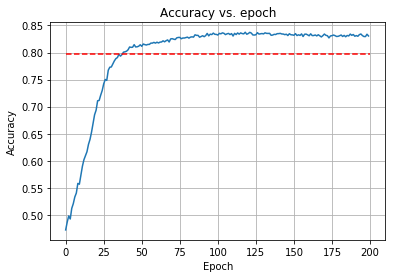

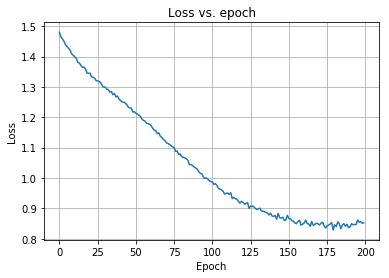

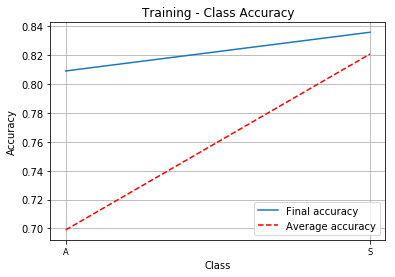

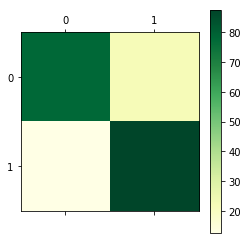

Running time: 686.91s


In [54]:
train_acc, train_class_acc, train_av_class_acc, train_loss, train_cm = neural.run_model(data=trainloader, 
                                                                          categories = categories, 
                                                                          model = baseline, optimizer = optimizer, 
                                                                          epochs = epochs, allow_cuda = True, 
                                                                          x_shape=(-1,features))

Model moved to GPU.
Data label mix [ 835 3372]
	Accuracy: 86.36% 	Loss: 0.40
	Class A Accuracy: 77.84%
	Class S Accuracy: 88.46%


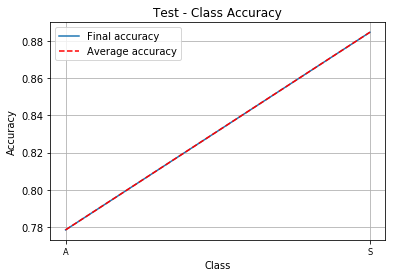

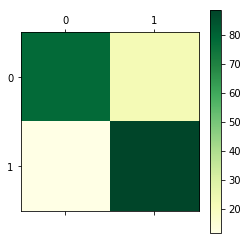

Running time: 0.49s


In [60]:
test_acc, test_class_acc, test_av_class_acc, test_loss, test_cm  = neural.run_model(data=testloader, 
                                                                       categories = categories, 
                                                                       model = baseline, optimizer=optimizer, 
                                                                       allow_cuda = True, x_shape=(-1,features), 
                                                                       train_mode=False)

In [61]:
train_data = {"Train File":filename, "Train Accuracy":train_acc, "Train Final Class Accuracy":train_class_acc,
              "Train Av Class Accuracy":train_av_class_acc, "Train Loss":train_loss, "Train CM": train_cm}
test_data = {"Test File":filename_t,"Test Accuracy":test_acc, "Test Final Class Accuracy":test_class_acc,
             "Test Av Class Accuracy":test_av_class_acc, "Test Loss":test_loss, "Test CM": test_cm}

PATH = r"D:\OneDrive\Documentos\CMU Classes\24787-B\Project\Models\current.pt"

neural.save_model(baseline, optimizer, epochs, categories, train_data, test_data, PATH)


C:\Users\varga\Anaconda3\envs\TensorFlow\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Baseline001. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Shallow Learning Alternatives

In [18]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [19]:
train_features = trainloader.dataset.features
train_labels = trainloader.dataset.labels

test_features = testloader.dataset.features
test_labels = testloader.dataset.labels

### 1) SVM

In [20]:
clf = svm.SVC(C=10, gamma="scale", degree=3)
clf.fit(train_features, train_labels)
svm_train_predict = clf.predict(train_features)
svm_test_predict = clf.predict(test_features)

In [21]:
svm_train_acc = np.sum(svm_train_predict == train_labels.squeeze())/len(train_labels)
svm_test_acc = np.sum(svm_test_predict == test_labels.squeeze())/len(test_labels)
print("SVM Training Accuracy: %.2f%%"%(svm_train_acc*100))
print("SVM Test Accuracy: %.2f%%"%(svm_test_acc*100))

SVM Training Accuracy: 88.85%
SVM Test Accuracy: 54.84%


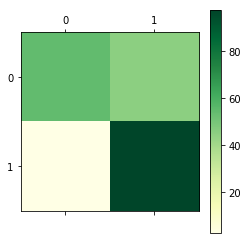

Categories ['A', 'S']
Confusion Matrix:
[[ 2279  1893]
 [  453 16408]]


In [22]:
svm_cm = confusion_matrix(train_labels, svm_train_predict)
row_sum = svm_cm.sum(axis = 1, keepdims=True)
plt.matshow(np.round(100*svm_cm/row_sum,1), cmap=plt.cm.YlGn) #gray
plt.colorbar()
plt.show()
print("Categories",list(categories))
print("Confusion Matrix:",svm_cm,sep="\n")

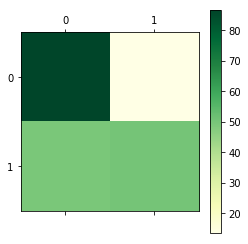

Categories ['A', 'S']
Confusion Matrix:
[[1873  288]
 [7909 8080]]


In [23]:
svm_test_cm = confusion_matrix(test_labels, svm_test_predict)
row_sum_test = svm_test_cm.sum(axis = 1, keepdims=True)
plt.matshow(np.round(100*svm_test_cm/row_sum_test,1), cmap=plt.cm.YlGn) #gray
plt.colorbar()
plt.show()
print("Categories",list(categories))
print("Confusion Matrix:",svm_test_cm,sep="\n")

## SVM Additional Subcategorization

In [ ]:
#filename = "B00010.2classes.max.pt"     
#baseline, optimizer, epochs, categories, train_data, test_data = neural.load_model(filename)

In [ ]:
#train_predictions, train_labels = neural.predict(trainloader, baseline, allow_cuda = True, x_shape = (-1,features))

Train SVM

In [ ]:
# The data predicted to be phase A
#A_data = data_part[train_labels == 0]
#A_labels = data_original_cats[train_labels == 0]
#A_data = pd.concat([A_data,A_labels], axis = 1)
#A_data.columns = ['delta 1', 'theta 1', 'alpha 1', 'sigma 1', 'beta 1', 'delta 2', 'theta 2', 'alpha 2',
#       'sigma 2', 'beta 2', 'emg', 'eog']

In [ ]:
#from sklearn import svm
#clf = svm.SVC(C=10, gamma="scale", degree=3)
#clf.fit(A_data, A_labels)

In [ ]:
#svm_train_acc = np.sum(clf.predict(A_data) == A_labels.squeeze())/len(A_labels)
#print("SVM Training Accuracy: %.2f%%"%(svm_train_acc*100))

In [ ]:
#A_data = data_part[train_predictions == 0]
#A_labels = data_original_cats[train_predictions == 0]
#svm_prediction = clf.predict(A_data)
#svm_test_acc = np.sum(svm_prediction == A_labels.squeeze())/len(A_labels)
#print("SVM Test Accuracy: %.2f%%"%(svm_test_acc*100))

In [ ]:
#A_data

In [59]:
# RELOAD FILES!!!
from importlib import reload
functions = reload(functions)
neural = reload(neural)